<font size="4"><b>Оглавление </b></p></font> 
<a id='contents'></a>

1. [Постановка задания](#intro)
2. [Обзор данных](#data_review)
- [Выводы](#data_reviw_summary)
3. [Сплит данных на выборки](#data_split)
- [Разделение](#split)
- [Выводы](#data_split_summary)
4. [Построение моделей](#model_initialisation)
- [Решающее дерево](#1st_model)
- [Случайный лес](#2d_model)
- [Логистическая регрессия](#3d_model)
- [Сравнение Моделей](#models_comparing)
- [Проверка моделей на тестовой выборке](#test_data_check)
5. [Проверка на вменяемость](#model_responsibility)
6. [Итоги исследования](#summary)

<a id='intro'></a>

In [33]:
import pandas as pd

pd.options.display.float_format ='{:,.3f}'.format

import seaborn as sb

import matplotlib.pyplot as plt

import numpy as np

import time

import os

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

# **Исследование по рекомендации тарифа**

**Заказчик** — федеральный оператор сотовой связи «Мегалайн».

**Цель исследования**:
1. Построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Поставленные задачи**
1. Изучить предобработанные данные по действующим пользователям тарифов «Смарт» или «Ультра».
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры, для выбора оптимальной. Минимальная доля правильных ответов должна составлять 0.75.
4. Проверить качество выбранной модели на тестовой выборке.
5. Проверить модели на вменяемость.

**Дальнейшее использование**

Результаты исследования будут использоваться в дальнейшем при предложении пользователям одного из двух тарифных планов для перехода с архивных. 

**Дополнительно предоставленная инфомарция о тарифах**

***Тариф «Смарт»***
- Ежемесячная плата, руб.	550	
- Включено: (мин/смс/Гб)	500/50/15	
- Сверх пакета, ру.: (мин/смс/Гб)	3/3/200	

***Тариф «Ультра»***
- Ежемесячная плата, руб.	1950	
- Включено: (мин/смс/Гб)	3000/1000/30	
- Сверх пакета, ру.: (мин/смс/Гб)	1/1/150

[К оглавлению](#contents)

<a id='data_review'></a>

## **I. Обзор данных**

В ходе исследования нам понадобятся библиотеки и модули:

* `pandas`
* `seaborn`
* `matplotlib.pyplot`
* `numpy`
* `time`
* `os`
* `sklearn`:
    - `metrics`
    - `ensemble`
    - `tree`
    - `linear_model`    
    - `model_selection`

Алгоритмы из модулей выше:
* `accuracy_score`
* `train_test_split`
* `DecisionForestClassifier`
* `RandomForestClassifier`
* `LogisticRegression`

Сначала составим представление о полученных исходных данных.
Для этого используем библиотеку `pandas`.

Импортируем библиотеку и прочитаем файл `users_behavior.csv` из папки `/datasets/` и сохраним его в переменной `df`:

In [2]:
import os

pth1 = 'D:/Programs/Jupyter_projects/datasets/users_behavior.csv'
pth2 = '/datasets/users_behavior.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, sep=',')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, sep=',')
else:
    print('Something is wrong')

Выведем на экран первые пять строк таблицы:

In [3]:
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.000,311.900,83.000,"19,915.420",0
1,85.000,516.750,56.000,"22,696.960",0
2,77.000,467.660,86.000,"21,060.450",0
3,106.000,745.530,81.000,"8,437.390",1
4,66.000,418.740,1.000,"14,502.750",0


Получим общую информацию о таблице: <a id='df.info'></a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Итак, в таблице 5 столбцов. Типы данных в столбцах — целые числа `int` и вещественные числа `float`.

Согласно документации к данным:

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Количество значений в столбцах соотнесены. Значит, в данных неи **пропущенных значений** и данные предобработаны.

В названиях колонок нарушений стиля нет.

Посмотрим на распределение признаков, от которых будет зависеть наш тариф

array([[<AxesSubplot:title={'center':'minutes'}>,
        <AxesSubplot:title={'center':'calls'}>],
       [<AxesSubplot:title={'center':'mb_used'}>,
        <AxesSubplot:title={'center':'messages'}>]], dtype=object)

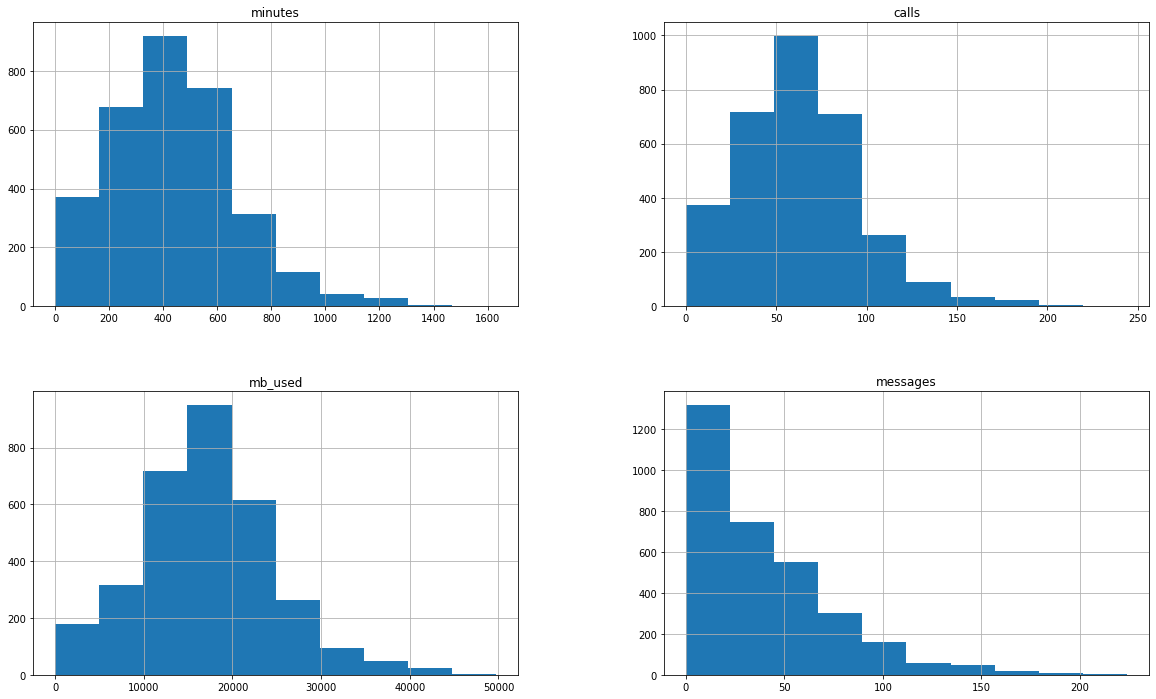

In [56]:
features_t = list(set(df.columns) - set(['is_ultra']))
df[features_t].hist(figsize=(20,12))

Видим, что большинство признаков распределены нормально. Исключения – число SMS-сообщений (messages) (пик в нуле, т.е. это те клиенты, кто вообще не пользуется смс-сообщениями).

Построим матрицу диаграмм, где на главной диагонали видим распределения признаков, а вне главной диагонали – диаграммы рассеяния для пар признаков (целевым признаком укажем действующий тариф: «Ультра» — 1, «Смарт» — 0).

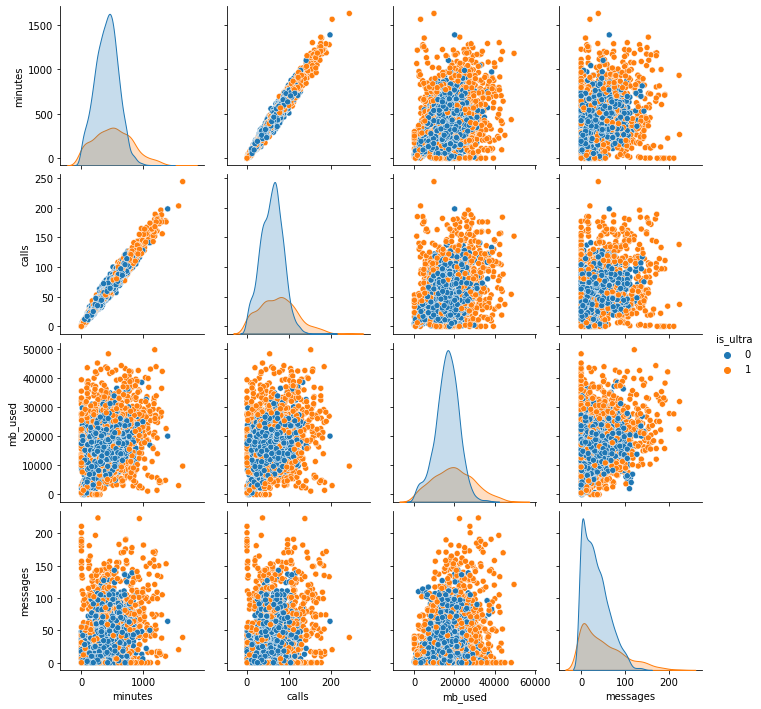

In [57]:
sb.pairplot(df[features_t + ['is_ultra']], hue='is_ultra')

И выведем также корреляцию в виде таблицы

In [59]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000,0.982,0.177,0.286,0.207
minutes,0.982,1.000,0.173,0.281,0.207
messages,0.177,0.173,1.000,0.196,0.204
mb_used,0.286,0.281,0.196,1.000,0.199
is_ultra,0.207,0.207,0.204,0.199,1.000


Влияние всех сервисов на подключенный тариф примерно одинаковое и прямо пропорциональное

<a id='data_reviw_summary'></a>

### **Выводы**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц: его звонки, длительность разговоров, SMS-сообщения, интернет трафик и действующий тариф. Все данные характеризуют бизнес отношения клияента с оператором.

[К оглавлению](#contents)

<a id='data_split'></a>

## **II. Сплит данных на выборки**

<a id='split'></a>

### 1. Разделение

Предоставленные данные представляют собой один единый датафрейм, разделения на обучающую, тестовую и валидационную выборки у нас сейчас нет. Поэтому сделаем выполним это сейчас с помощью алгоритма `train_test_split` в соотношении 3:1:1.

Введем переменную с признаками и с целевым признаком по всему датафрейму

In [6]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Сначала отделим тестовую выборку от тренировочной, которая будет составлять 20% от всех исходных данных, остаток будет обучающая+валидационная. Тестовую будем использовать для для оценки эффективности полностью обученного классификатора.

In [7]:
features, features_test, target, target_test = train_test_split(features, target, test_size=.2, random_state=12345)

Далее уже разделим на обучающую и валидационную с частью 25%. На обучающей будем выборке будем обучать нашу модель с подгоном параметров. Валидационную будем использовать для настройки параметров классификатора.

In [8]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=12345)

Посмотрим на размеры получившихся выборок:

In [9]:
# добавим все выборки в словарь
arrays = {
    'обучающая' : features_train,
    'валидационная' : features_valid,
    'тестовая' : features_test}

In [10]:
# выведем количество содержащихся объектов
for array_name, array in arrays.items():
    print("\033[4m\033[1m\033[31m{}\033[0m содержит объектов:".format(f'{array_name} выборка'), array.shape[0], f'({array.shape[0]/df.shape[0]:.1%})')

обучающая выборка содержит объектов: 1928 (60.0%)
валидационная выборка содержит объектов: 643 (20.0%)
тестовая выборка содержит объектов: 643 (20.0%)


<a id='data_split_summary'></a>

### 2. Вывод

Получили равные выборки в отношении 3:1:1, которые будем использовать уже для создания наших моделей. Так как в исследовании необходимым целевым признаком является категориальный параметр (нужно ответить на вопрос, какой тариф больше подхоит: «Смарт» или «Ультра»), следовательно будем использовать модель через классификацию. 

[К оглавлению](#contents)

<a id='model_initialisation'></a>

## **III. Построение моделей**

<a id='1st_model'></a>

### 1. Модель «Решающее дерево»

Рассмотрим первый тип модели: используя алгоритм `решающее дерево` и поиграемся с его гиперпараметром глубины для задания максимального количества условий. Через цикл определим лучшую глубину дерева и соответствующую модель данного типа.

In [11]:
best_tree_model = None
best_tree_depth = 0
best_tree_result = 0
tree_model_time = 0

#сначала задал большой разбег с шагом 3-5, чтобы определить промежуток
#for depth in range(1, 45, 3):

#затем более точечно уже
for depth in range(2, 13):
    
# засекаем время
    start_time = time.time()
    
# создаем модельку
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
# кормим ей валидационную выбоку и смотрим на качество опреления целевого признака
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
#    print("max_depth =", depth, ": ", end='')
#    print(result)
    tree_model_time = (time.time() - start_time)
    
# сравниваем с лучшим качеством, если находим превосходящую, то перезаписываем модель и отсчитываем время обучения лучшей модели
    if result > best_tree_result:
        best_tree_model = model
        best_tree_result = result
        best_tree_depth = depth
        tree_model_time = tree_model_time

print('\n\033[4m\033[1m\033[31m{}\033[0m'.format(f'Accuracy лучшей модели: {best_tree_result} при глубине дерева решений {best_tree_depth}'))
print(f'Время выполнения обучения составляет {tree_model_time:.3f} секунд')


Accuracy лучшей модели: 0.7744945567651633 при глубине дерева решений 7
Время выполнения обучения составляет 0.008 секунд


Оптимальное **значение глубины**, при котором получаем лучший результат в **0.7745 точности** равен **7**.

[К оглавлению](#contents)

<a id='2d_model'></a>

### 2. Модель «Случайный лес»

Другим популярным алгоритмом является «Случайный лес», позволяющий построить целый «лес» независимых друг от друга «решающих деревьев», затем выбрать лучшее.

In [12]:
best_forest_model = None
best_forest_result = 0
best_forest_n_estimators = 0
forest_model_time = 0

#сначала задал большой разбег с шагом 3-5, чтобы определить промежуток
#for est in range(1, 500, 10):

#затем более точечно уже
for est in range(120, 180):
    
# засекаем время обучения
    start_time = time.time()
    
# создаем модельку
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    
# кормим ей валидационную выбоку и смотрим на качество опреления целевого признака

    result = model.score(features_valid, target_valid)
#    print("max_estimators =", est, ": ", end='')
#    print(result)
    forest_model_time = (time.time() - start_time)

# сравниваем с лучшим качеством, если находим превосходящую, то перезаписываем модель и отсчитываем время обучения лучшей модели
    if result > best_forest_result:
        best_forest_model = model
        best_forest_result = result
        best_forest_n_estimators = est
        forest_model_time = forest_model_time

print('\n\033[4m\033[1m\033[31m{}\033[0m'.format(f'Accuracy лучшей модели: {best_forest_result} при количестве рассматриваемых деревьев {best_forest_n_estimators}'))

print(f'Время выполнения обучения составляет {forest_model_time:.3f} секунд')


Accuracy лучшей модели: 0.8009331259720062 при количестве рассматриваемых деревьев 146
Время выполнения обучения составляет 0.943 секунд


Оптимальное **количество деревьев**, при котором получаем лучший результат в **0.8009 точности** равен **146**. Код при этом выполняется достаточно долго и обучение происходит медленно.

[К оглавлению](#contents)

<a id='3d_model'></a>

### 3. Модель «Логистическая регрессия»

Последним алгоритмом классификатора является «Логистическая регрессия», который сравнивает к какому тарифу ближе объект/клиент (например, основываясь на большей важности интернет трафика нежели СМС сообщений) и в зависимости ответа выбирает тариф.

In [13]:
best_log_regression_model = None
best_log_regression_result = 0
best_log_regression_iter = 0
log_regression_model_time = 0

for iter in range (100, 1000, 100):
    
# засекаем время
    start_time = time.time()

# создаем модельку
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter) 
    model.fit(features_train, target_train)
    
# кормим ей валидационную выбоку и смотрим на качество опреления целевого признака
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
#    print("max_iter =", iter, ": ", end='')
#    print(result)
    log_regression_model_time = (time.time() - start_time)
    
# сравниваем с лучшим качеством, если находим превосходящую, то перезаписываем модель и отсчитываем время обучения лучшей модели
    if result > best_log_regression_result:
        best_log_regression_model = model
        best_log_regression_result = result
        best_log_regression_iter = iter
        log_regression_model_time = log_regression_model_time

print('\n\033[4m\033[1m\033[31m{}\033[0m'.format(f'Accuracy лучшей модели: {best_log_regression_result} при количестве итераций {best_log_regression_iter}'))
print(f'Время выполнения обучения составляет {log_regression_model_time:.3f} секунд')


Accuracy лучшей модели: 0.7262830482115086 при количестве итераций 100
Время выполнения обучения составляет 0.026 секунд


Оптимальное **число итераций**, при котором получаем лучший результат в **0.7263 точности** равен **100**. Код при этом выполняется быстро.

[К оглавлению](#contents)

<a id='models_comparing'></a>

### 4. Сравнение моделей 

Выведем все получившиеся оптимальные параметры и гиперпараметры моделей и их качество:

In [14]:
models_description = [
    ['Решающее дерево', best_tree_result, f'Глубина ветвления', best_tree_depth, tree_model_time],
    ['Случайный лес', best_forest_result, 'Количество деревьев', best_forest_n_estimators, forest_model_time],
    ['Логистическая регрессия', best_log_regression_result, 'Количество итераций', best_log_regression_iter, log_regression_model_time]
]

columns = ['Модель', 'Лучшее качество при обучении', 'Гиперпараметр', 'Лучшее значение', 'Время выполнения оптимального параметра']

In [15]:
models_summary = pd.DataFrame(data=models_description, columns=columns)
models_summary

,Модель,Лучшее качество при обучении,Гиперпараметр,Лучшее значение,Время выполнения оптимального параметра
0,Решающее дерево,0.774,Глубина ветвления,7,0.008
1,Случайный лес,0.801,Количество деревьев,146,0.943
2,Логистическая регрессия,0.726,Количество итераций,100,0.026


**Выводы**

По итогу создания моделей мы видим:
* лучшее качество на обучении показала модель, построенная на алгоритме «Случайный лес» в **0.8 пункт**, однако для достижения такого показателя необходимо построить 146 независимых решающих деревьев, что напрямую влияет на время обучения (почти 0.54 секунд на локальной машине против 0.01 на одном решающем дереве).
* модель, построенная на алгоритме «Логистическая регрессия» показала самый плохой результат по качеству в **0.72 пункта** и среднем показателе времени 0.02 секунды
* модель, построенная на алгоритме «Решающее дерево» показала лучший результат по скорости обучения в 0.01 секунды при качестве в **0.77 пункта**, однако следует проверить наши лучшие модели на тестовой выборке для проверки на переобучаемость или недообучаемость.


[К оглавлению](#contents)

<a id='test_data_check'></a>

### 5. Проверка моделей на тестовой выборке

Проверим наши лучшие модели на тестовой выбоке, чтобы убедиться в их качестве

In [16]:
# добавим все лучшие модели в словарь для быстрого доступа к названию и самой модели
models = {'Решающее дерево':best_tree_model,
          'Случайный лес':best_forest_model,
          'Логистическая регрессия':best_log_regression_model
         }

In [17]:
# создадим пустой список для последующего добавления в обзорную таблицу лучших моделей
accuracy_tests = []

# через цикл, обращаясь к словарю моделей, определим качество моделей по тестовой выборке
for name, model in models.items():
    test_predictions = model.predict(features_test)
    accuracy_test = accuracy_score(target_test, test_predictions)
    accuracy_tests.append(accuracy_test)
    print(f'Тестовая выборка на модели {name}:', accuracy_test)

# создадим новый столбец в выводной таблице по лучшим моделям
models_summary['Качество при тесте'] =  accuracy_tests

Тестовая выборка на модели Решающее дерево: 0.7884914463452566
Тестовая выборка на модели Случайный лес: 0.7884914463452566
Тестовая выборка на модели Логистическая регрессия: 0.7589424572317263


Выведем еще раз итоговую таблицу

In [18]:
models_summary

,Модель,Лучшее качество при обучении,Гиперпараметр,Лучшее значение,Время выполнения оптимального параметра,Качество при тесте
0,Решающее дерево,0.774,Глубина ветвления,7,0.008,0.788
1,Случайный лес,0.801,Количество деревьев,146,0.943,0.788
2,Логистическая регрессия,0.726,Количество итераций,100,0.026,0.759


**Выводы**

По итогу проверки на тестовых данных:
* модель «Случайный лес» и «Решающее дерево» показали одинаковое качество, однако скорость обучаемости второй в много раз превосходит первую, поэтому лучшим выбором будет использовать модель, построенную на основе алгоритма «Решающее дерево»
* тестовые значения у второй модели ниже чем при обучении, такое различие может быть связано с отличиями в распределении данных в тестовой и валидационной выборках. В какой-то незначительной степени имеет место переобучение, но такие небольшие колебания допустимы.

[К оглавлению](#contents)

<a id='model_responsibility'></a>

## **IV. Проверка моделей на вменяемость**

Настало время проверить наши модели на адекватность сравнив их со случайными результатами, которые игнорируют правило входных данных. И если модель ведет себя лучше, то значит она может извлекать какой-то сигнал из данных и имеет предсказательную силу.
Для этого воспользуемся `sklearn.dummy.DummyClassifier`

In [19]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = features_test
y = target_test
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)
print(f'Accuracy: {dummy_clf.score(X, y)}')

Accuracy: 0.6951788491446346


Если я правильно понимаю, то это всё. Мы просто посчитали количество угадываний в выборке. Наши лучшие модели показали качество лучше: 0.788 против 0.695, следовательно имеет смысл использовать модели машинного обучения. 

Еще прочитал про модель по алгоритму градиентного бустинга, которая вбирает в себя гиперпараметры рассмотренных в проекте алгоритмов и позволяет показывать чаще всего лучшие результаты за счет более слабых классификаторов с последующим повышением точности прогнозирования с помощью изменения веса значимости правильно спрогнозированных и неправильно спрогнозированных объектов.

[К оглавлению](#contents)

<a id='summary'></a>

## **V. Итоги исследования**

На основании предобработанных данных, предоставленных оператором, мы создали несколько моделей, выбрали лучшую и проверили их на адекватность. И вот что у нас получилось:

In [20]:
models_summary

,Модель,Лучшее качество при обучении,Гиперпараметр,Лучшее значение,Время выполнения оптимального параметра,Качество при тесте
0,Решающее дерево,0.774,Глубина ветвления,7,0.008,0.788
1,Случайный лес,0.801,Количество деревьев,146,0.943,0.788
2,Логистическая регрессия,0.726,Количество итераций,100,0.026,0.759


Лучшей моделью (среди трех рассмотренных) для решения поставленной цели будет являться модель на основе алгоритма «Решающее дерево» с точностью в 0.788 и самой быстрой скоростью обучения.

[К оглавлению](#contents)